<a href="https://colab.research.google.com/github/malakelbasha78/AI-Skills-Projects/blob/main/models/MobileNetV2/MobileNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kagglehub -q

import kagglehub
path = kagglehub.dataset_download("divyasharma20/plantv")
print("Path to dataset files:", path)

import os
import shutil
from PIL import Image
import hashlib
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler, random_split
from torchvision import datasets, transforms, models
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

100%|██████████| 825M/825M [00:03<00:00, 247MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/divyasharma20/plantv/versions/1


In [ ]:
plantv_path = os.path.join(path, "PlantVillage")
train_path = os.path.join(plantv_path, "train")
val_path = os.path.join(plantv_path, "val")

merged_path = "/content/PlantVillage_all"
os.makedirs(merged_path, exist_ok=True)

classes = os.listdir(train_path)
for cls in classes:
    os.makedirs(os.path.join(merged_path, cls), exist_ok=True)
    for img in os.listdir(os.path.join(train_path, cls)):
        shutil.copy(os.path.join(train_path, cls, img), os.path.join(merged_path, cls, img))
    for img in os.listdir(os.path.join(val_path, cls)):
        shutil.copy(os.path.join(val_path, cls, img), os.path.join(merged_path, cls, img))

print("Successfully merged train + val!")

Successfully merged train + val!


In [ ]:
# ====================== 2. Data Cleaning======================
# Remove duplicates
def remove_duplicates(dataset_path):
    hashes = {}
    removed = 0
    for cls in os.listdir(dataset_path):
        cls_path = os.path.join(dataset_path, cls)
        for img_name in os.listdir(cls_path):
            img_path = os.path.join(cls_path, img_name)
            with Image.open(img_path) as img:
                h = hashlib.md5(img.tobytes()).hexdigest()
            if h in hashes:
                os.remove(img_path)
                removed += 1
            else:
                hashes[h] = img_path
    print(f"Removed {removed} duplicate images")


remove_duplicates(merged_path)






Removed 24 duplicate images


In [ ]:
# Enhance blurry images
def enhance_blurry(dataset_path, threshold=100):
    kernel = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]])
    for cls in os.listdir(dataset_path):
        cls_path = os.path.join(dataset_path, cls)
        for img_name in os.listdir(cls_path):
            img_path = os.path.join(cls_path, img_name)
            img = cv2.imread(img_path)
            if img is None: continue
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            if cv2.Laplacian(gray, cv2.CV_64F).var() < threshold:
                sharp = cv2.filter2D(img, -1, kernel)
                cv2.imwrite(img_path, sharp)

enhance_blurry(merged_path)

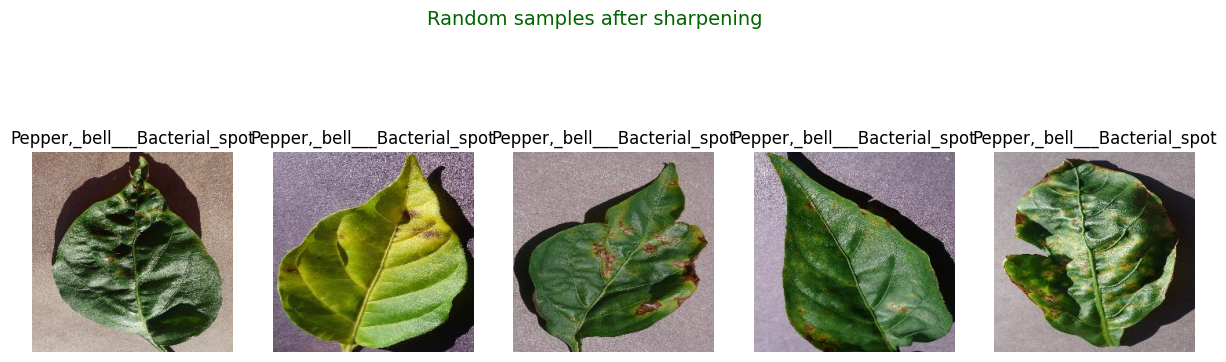

In [ ]:
# ====================== Visualization: Check images after Sharpening ======================
import random
import cv2
import matplotlib.pyplot as plt

cls = random.choice(os.listdir(merged_path))
cls_path = os.path.join(merged_path, cls)

sample_images = random.sample(os.listdir(cls_path), 5)

plt.figure(figsize=(15,5))
for i, img_name in enumerate(sample_images):
    img_path = os.path.join(cls_path, img_name)
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(1, 5, i+1)
    plt.imshow(img_rgb)
    plt.title(f"{cls}")
    plt.axis('off')

plt.suptitle("Random samples after sharpening", fontsize=14, color='darkgreen')
plt.show()


In [ ]:
# Convert all images to RGB
for cls in os.listdir(merged_path):
    cls_path = os.path.join(merged_path, cls)
    for img_name in os.listdir(cls_path):
        img_path = os.path.join(cls_path, img_name)
        try:
            img = Image.open(img_path)
            if img.mode != "RGB":
                img.convert("RGB").save(img_path)
        except: pass

print("Data cleaning completed!")

Data cleaning completed!


In [ ]:
# ====================== 3. Prepare dataset ======================
full_dataset = datasets.ImageFolder(merged_path)

train_size = int(0.70 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(0.3,0.3,0.3,0.1),
    transforms.RandomResizedCrop(224, scale=(0.8,1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])






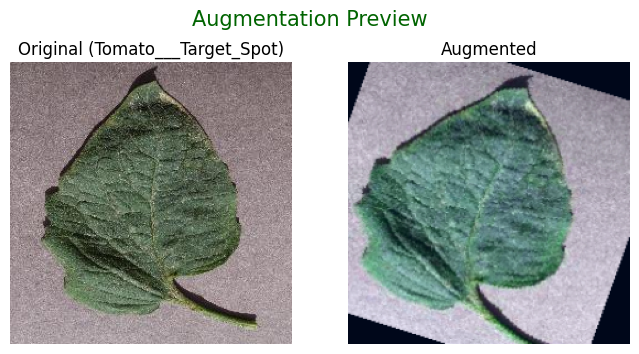

In [ ]:
# ====================== Visualization: Augmentation Example ======================
import random
from PIL import Image

idx = random.randint(0, len(train_dataset)-1)
img_pil, label = train_dataset[idx]  # Raw PIL image

plt.figure(figsize=(8,4))

# Original
plt.subplot(1,2,1)
plt.imshow(img_pil)
plt.title(f"Original ({full_dataset.classes[label]})")
plt.axis('off')

# Augmented
aug_img = train_transforms(img_pil)
aug_np = aug_img.permute(1,2,0).numpy()
aug_np = (aug_np - aug_np.min()) / (aug_np.max() - aug_np.min())

plt.subplot(1,2,2)
plt.imshow(aug_np)
plt.title("Augmented")
plt.axis('off')

plt.suptitle("Augmentation Preview", fontsize=15, color='darkgreen')
plt.show()

class TransformedSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
    def __getitem__(self, idx):
        img, label = self.subset[idx]
        if self.transform:
            img = self.transform(img)
        return img, label
    def __len__(self):
        return len(self.subset)

train_dataset = TransformedSubset(train_dataset, train_transforms)
val_dataset = TransformedSubset(val_dataset, val_test_transforms)
test_dataset = TransformedSubset(test_dataset, val_test_transforms)

# Solve imbalance issue
train_labels = [full_dataset.targets[i] for i in train_dataset.subset.indices]
class_counts = np.bincount(train_labels)
class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
sample_weights = class_weights[train_labels]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

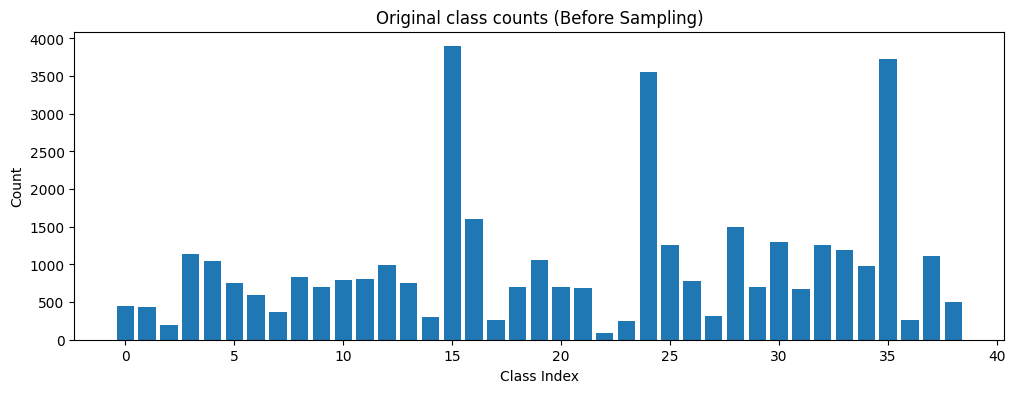

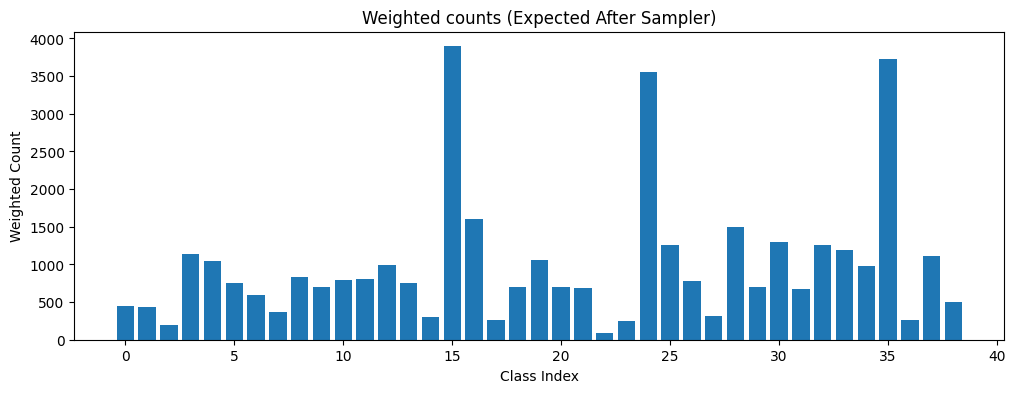

In [ ]:
# ====================== Visualization: Imbalance Before & After Sampler ======================
import matplotlib.pyplot as plt
import numpy as np

# Original class distribution
plt.figure(figsize=(12,4))
plt.bar(range(len(class_counts)), class_counts)
plt.title("Original class counts (Before Sampling)")
plt.xlabel("Class Index")
plt.ylabel("Count")
plt.show()

# Weighted distribution (expected)
weighted_counts = [0]*len(class_counts)
for w in sample_weights:
    weighted_counts[int(np.argmin(np.abs(class_weights.numpy() - w.numpy())))] += 1

plt.figure(figsize=(12,4))
plt.bar(range(len(class_counts)), weighted_counts)
plt.title("Weighted counts (Expected After Sampler)")
plt.xlabel("Class Index")
plt.ylabel("Weighted Count")
plt.show()


train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

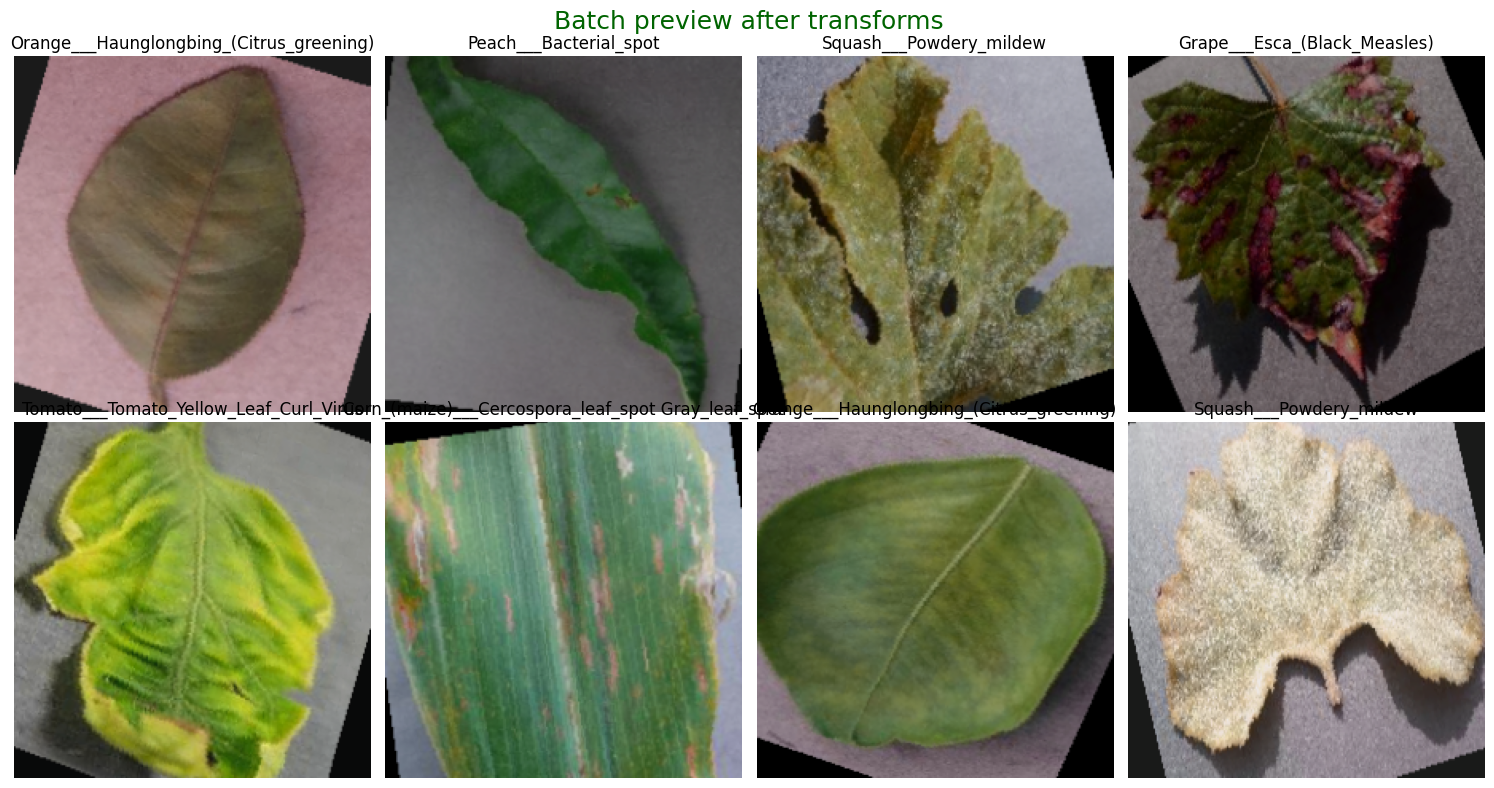

Device: cuda


In [ ]:
# ====================== Visualization: First Batch Preview ======================
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

batch_size = 8

# loader للعرض فقط بدون sampler
train_loader_display = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

batch_imgs, batch_labels = next(iter(train_loader_display))

plt.figure(figsize=(15,8))
for i in range(batch_size):
    img = batch_imgs[i].permute(1,2,0).numpy()

    # Undo normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)

    plt.subplot(2,4,i+1)
    plt.imshow(img)
    plt.title(full_dataset.classes[batch_labels[i].item()])
    plt.axis('off')

plt.suptitle("Batch preview after transforms", fontsize=18, color='darkgreen')
plt.tight_layout()
plt.show()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


In [ ]:
# ====================== 4.Model + Train Head ======================
model = models.mobilenet_v2(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 39)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

print("Training Head only (8 epochs)...")
for epoch in range(8):
    model.train()
    running_loss = 0.0
    correct = total = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        correct += (out.argmax(1) == y).sum().item()
        total += y.size(0)
    print(f"Head Epoch {epoch+1}/8 - Loss: {running_loss/len(train_loader):.4f} - Acc: {100*correct/total:.2f}%")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 43.1MB/s]


Training Head only (8 epochs)...
Head Epoch 1/8 - Loss: 0.8147 - Acc: 78.62%
Head Epoch 2/8 - Loss: 0.4358 - Acc: 86.58%
Head Epoch 3/8 - Loss: 0.3976 - Acc: 87.32%
Head Epoch 4/8 - Loss: 0.3854 - Acc: 87.59%
Head Epoch 5/8 - Loss: 0.3773 - Acc: 87.81%
Head Epoch 6/8 - Loss: 0.3700 - Acc: 88.11%
Head Epoch 7/8 - Loss: 0.3782 - Acc: 87.88%
Head Epoch 8/8 - Loss: 0.3639 - Acc: 88.36%


In [ ]:
# ====================== 5.  Full Fine-Tuning======================
print("\nStarting full model Fine-Tuning...")
for param in model.parameters():
    param.requires_grad = True

optimizer = optim.Adam([
    {'params': model.features.parameters(), 'lr': 1e-5},
    {'params': model.classifier.parameters(), 'lr': 1e-4}
], weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

best_val = 0.0
for epoch in range(10):
    model.train()
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            correct += (out.argmax(1) == y).sum().item()
            total += y.size(0)
    val_acc = 100 * correct / total
    print(f"Fine-Tune Epoch {epoch+1}/10 - Val Acc: {val_acc:.2f}%")
    if val_acc > best_val:
        best_val = val_acc
        torch.save(model.state_dict(), '/content/best_plant_model.pth')
    scheduler.step()

model.load_state_dict(torch.load('/content/best_plant_model.pth'))
print(f"\nFine-Tuning completed! Best Validation Accuracy: {best_val:.2f}%")


Starting full model Fine-Tuning...
Fine-Tune Epoch 1/10 - Val Acc: 95.04%
Fine-Tune Epoch 2/10 - Val Acc: 96.33%
Fine-Tune Epoch 3/10 - Val Acc: 96.91%
Fine-Tune Epoch 4/10 - Val Acc: 97.03%
Fine-Tune Epoch 5/10 - Val Acc: 97.91%
Fine-Tune Epoch 6/10 - Val Acc: 97.60%
Fine-Tune Epoch 7/10 - Val Acc: 97.70%
Fine-Tune Epoch 8/10 - Val Acc: 97.05%
Fine-Tune Epoch 9/10 - Val Acc: 97.51%
Fine-Tune Epoch 10/10 - Val Acc: 97.61%

Fine-Tuning completed! Best Validation Accuracy: 97.91%



Final Test Set Accuracy: 97.88%

Classification Report (Precision / Recall / F1):
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab     1.0000    0.9900    0.9950       100
                                 Apple___Black_rot     0.9903    0.9808    0.9855       104
                          Apple___Cedar_apple_rust     1.0000    1.0000    1.0000        37
                                   Apple___healthy     0.9923    0.9962    0.9942       260
                               Blueberry___healthy     1.0000    0.9909    0.9954       220
          Cherry_(including_sour)___Powdery_mildew     1.0000    0.9935    0.9968       155
                 Cherry_(including_sour)___healthy     0.9854    0.9854    0.9854       137
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot     0.8427    0.9494    0.8929        79
                       Corn_(maize)___Common_rust_     1.0000    0.9939    0.9970       

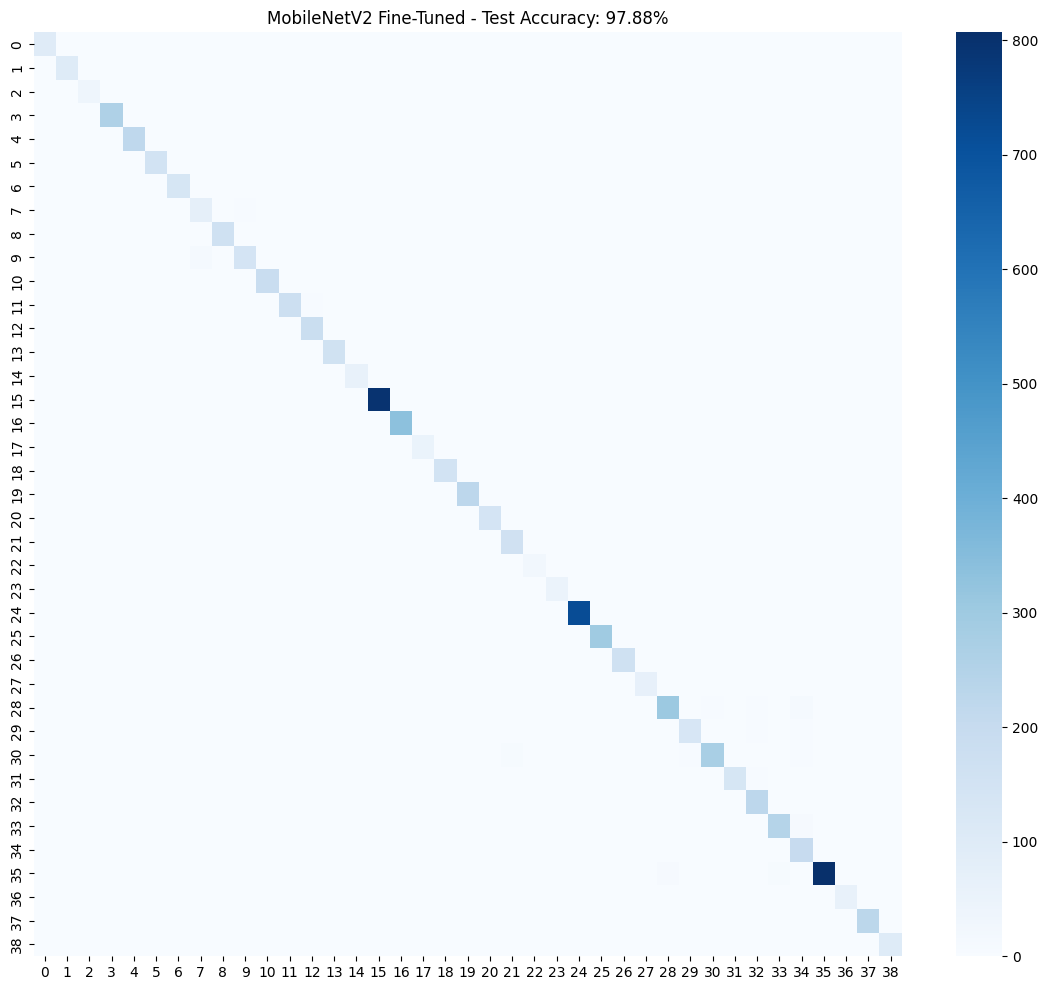

In [ ]:
# ====================== 6. Final Evaluation + Confusion Matrix  ======================
model.eval()
preds, trues = [], []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        out = model(x)
        preds.extend(out.argmax(1).cpu().numpy())
        trues.extend(y.numpy())

final_acc = accuracy_score(trues, preds)
print(f"\nFinal Test Set Accuracy: {final_acc*100:.2f}%")
plt.figure(figsize=(14,12))
sns.heatmap(confusion_matrix(trues, preds), annot=False, cmap="Blues")
plt.title(f"MobileNetV2 Fine-Tuned - Test Accuracy: {final_acc*100:.2f}%")
print("\nClassification Report (Precision / Recall / F1):")
print(classification_report(
    trues,
    preds,
    target_names=full_dataset.classes,
    digits=4
))

plt.show()

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


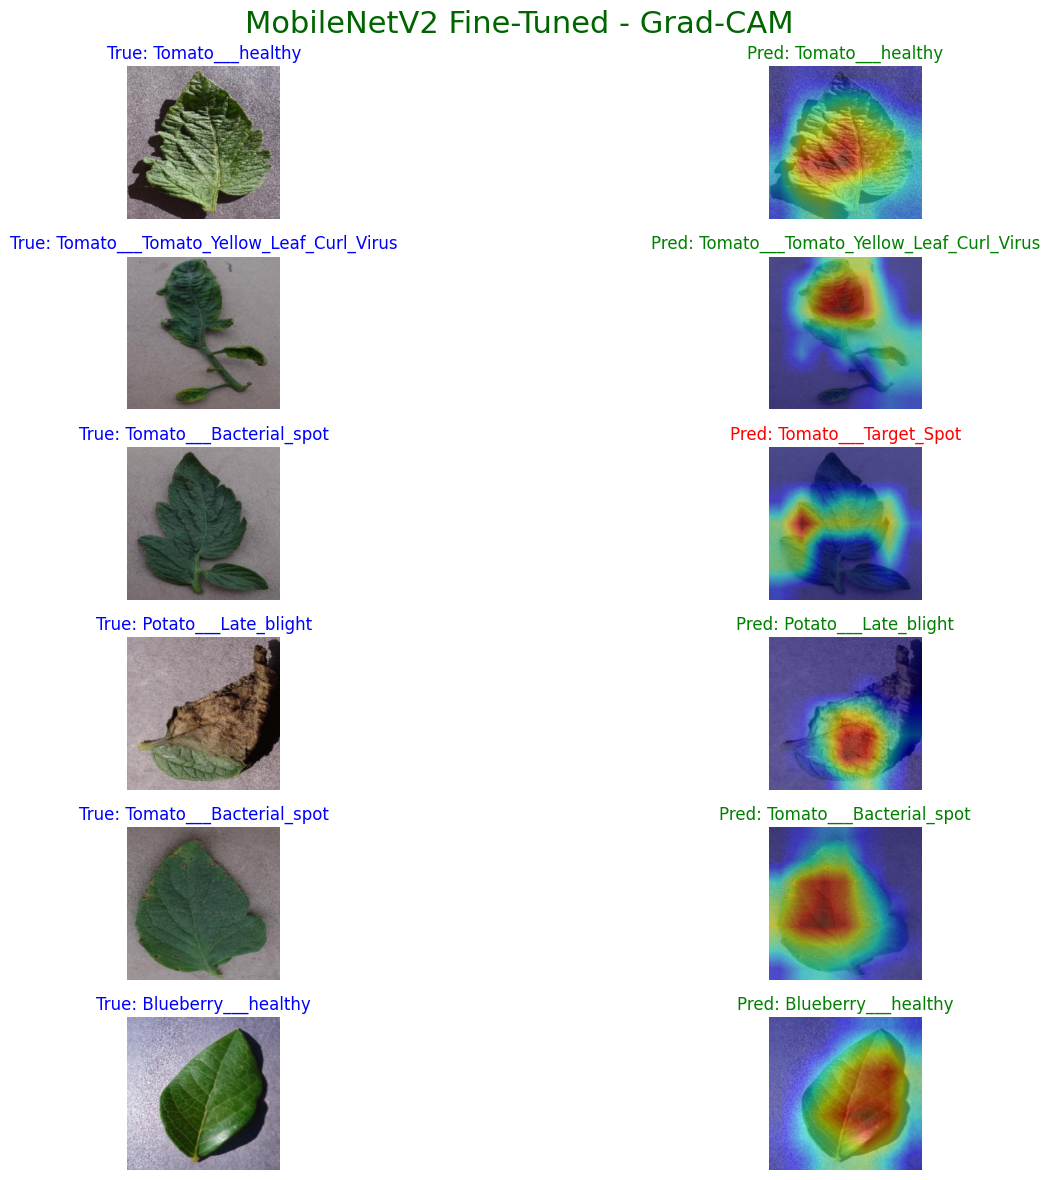

In [ ]:
# ====================== 7.  Grad-CAM ======================
activations = gradients = None

def hook_a(m, i, o): global activations; activations = o.detach()
def hook_g(m, gi, go): global gradients; gradients = go[0].detach()

hook1 = model.features[-1].register_forward_hook(hook_a)
hook2 = model.features[-1].register_backward_hook(hook_g)

def get_cam(img_tensor):
    global activations, gradients
    x = img_tensor.unsqueeze(0).to(device)
    logits = model(x)
    pred = logits.argmax(1).item()
    model.zero_grad()
    logits[0, pred].backward()
    weights = gradients.mean(dim=[2,3], keepdim=True)
    cam = (activations * weights).sum(dim=1).relu()[0].cpu().numpy()
    cam = cv2.resize(cam, (224,224))
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
    activations = gradients = None
    return cam, pred

plt.figure(figsize=(18,12))
test_iter = iter(test_loader)
for i in range(6):
    imgs, lbls = next(test_iter)
    img = imgs[0]
    true = lbls[0].item()
    cam, pred = get_cam(img)

    img_np = img.permute(1,2,0).cpu().numpy()
    img_np = np.clip(img_np * [0.229,0.224,0.225] + [0.485,0.456,0.406], 0, 1)

    plt.subplot(6,2,i*2+1)
    plt.imshow(img_np)
    plt.title(f"True: {full_dataset.classes[true]}", color="blue")
    plt.axis('off')

    plt.subplot(6,2,i*2+2)
    plt.imshow(img_np)
    plt.imshow(cam, cmap='jet', alpha=0.5)
    color = "green" if pred == true else "red"
    plt.title(f"Pred: {full_dataset.classes[pred]}", color=color)
    plt.axis('off')

plt.suptitle("MobileNetV2 Fine-Tuned - Grad-CAM ", fontsize=22, color='darkgreen')
plt.tight_layout()
plt.show()

hook1.remove()
hook2.remove()